- Notebook identifies the sub-clusters of astrocytes based on the astrocytic gene expression gradient with respect the boarder of striosome

In [ ]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import os

#### Sub-clustering of astrocytes based on the astrocytic gene that are showing gradient

In [ ]:
MERFISH_adata = ad.read_h5ad(r'./MERFISH_adata_QC/mapmycell_annotated_adata/MER2_Gpe_Gpi_CaPu_1311__MERFISH_annotated.h5ad')
spatialModuleAnnotation = pd.read_csv(r'./spatialDomain_analysis/processed_data/AP34a_MERFISH/GroupLevelspatialModule_MatrixStriosome_included_cleaned_final.csv', index_col=0)
MERFISH_adata.obs = MERFISH_adata.obs.join(spatialModuleAnnotation['MatrixStriosome_label'])
# get the distance from Striosome [as per the result from striosome celltype distribution analysis]
Striosome_distance = pd.read_csv(r'./processed_data/Donor_1311_posterior/Striosome_distance.csv',index_col = 0)
MERFISH_adata.obs = MERFISH_adata.obs.join(Striosome_distance)

In [ ]:
sign_astro_gn = np.load(r'./processed_data/AP26a_MERFISH/significant_astrocytic_gns.npy',allow_pickle = True)

In [13]:
# 1. replace the count with raw count matrix 
MERFISH_adata.X = MERFISH_adata.layers['X_raw'].copy()

# 2. restrict to astrocyte within and around the striosomes
dist_cond = (MERFISH_adata.obs['striosome_distance'] > -200) & (MERFISH_adata.obs['striosome_distance'] < 500)
cellType_cond = MERFISH_adata.obs['Group_name'].isin(['Astrocyte'])
subadata = MERFISH_adata[dist_cond & cellType_cond].copy()

# 3. restrict to the genes used in the gradient analysis
subadata= subadata[:,sign_astro_gn].copy()
subadata


AnnData object with n_obs × n_vars = 23320 × 74
    obs: 'volm', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'Neighborhood_label', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Class_label', 'Class_name', 'Class_bootstrapping_probability', 'Subclass_label', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Group_label', 'Group_name', 'Group_bootstrapping_probability', 'Cluster_label', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability', 'MatrixStriosome_label', 'striosome_distance'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'Ensemble_ID'
    uns: 'Class_name_colors', 'Group_name_colors', 'Subclass_name_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'umap'
  

In [14]:
## Count matrix normalization 
total_count = np.sum(subadata.X, axis = -1)
sc.pp.normalize_total(subadata,target_sum = np.median(total_count))
sc.pp.log1p(subadata)

/home/exx/.conda/envs/3D_Hippo_MERFISH_env/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


In [15]:
sc.pp.neighbors(subadata, n_neighbors=15, use_rep='X')
sc.tl.leiden(subadata,resolution = 0.3)
sc.tl.umap(subadata, min_dist = 0.1)

/tmp/ipykernel_452369/2836811053.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(subadata,resolution = 0.3)


In [16]:
np.unique(subadata.obs['leiden'])

array(['0', '1', '2', '3'], dtype=object)

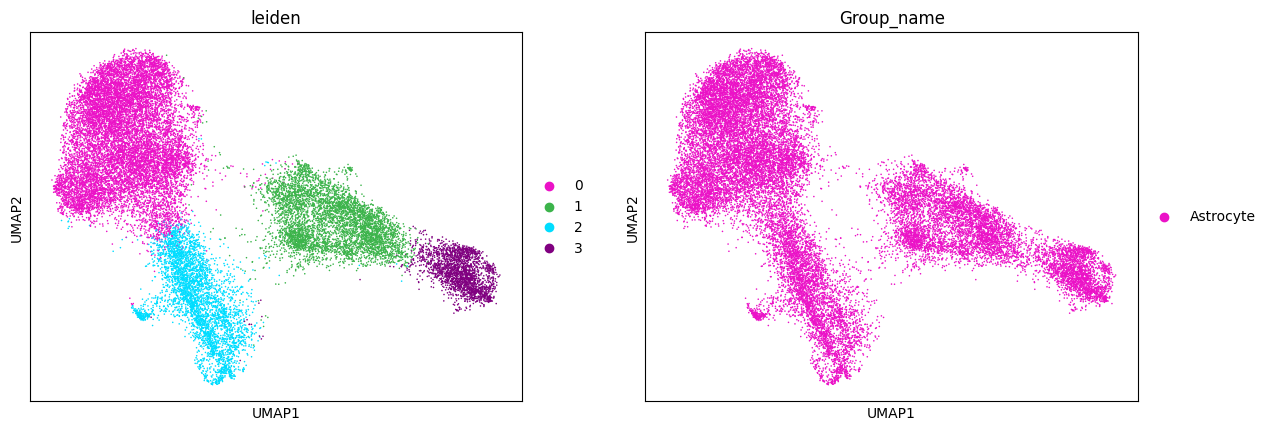

In [17]:
cmap = ["#e6194B", "#3cb44b","#4363d8", "#f58231", "#42d4f4","#911eb4", "#ffe119", "#bfef45", "#da1b1b",
        "#000075", "#aaffc3", "#808000", "#ffd8b1", "#f032e6",[0,0.2,0],
         "#fabed4", "#1AEBD3", "#dcbeff", "#9A6324", "#fffac8", "#800000",]
cmap = ["#EB12C7","#3cb44b", "#00DDFF",'#800080']
cmap = ["#EB12C7","#3cb44b", "#00DDFF",'#800080']
sc.pl.umap(subadata,color = ['leiden','Group_name'], palette = cmap )

In [19]:
subadata.obs['leiden_annotated'] = subadata.obs['leiden'].map(lambda x: f'Astro-{x}')

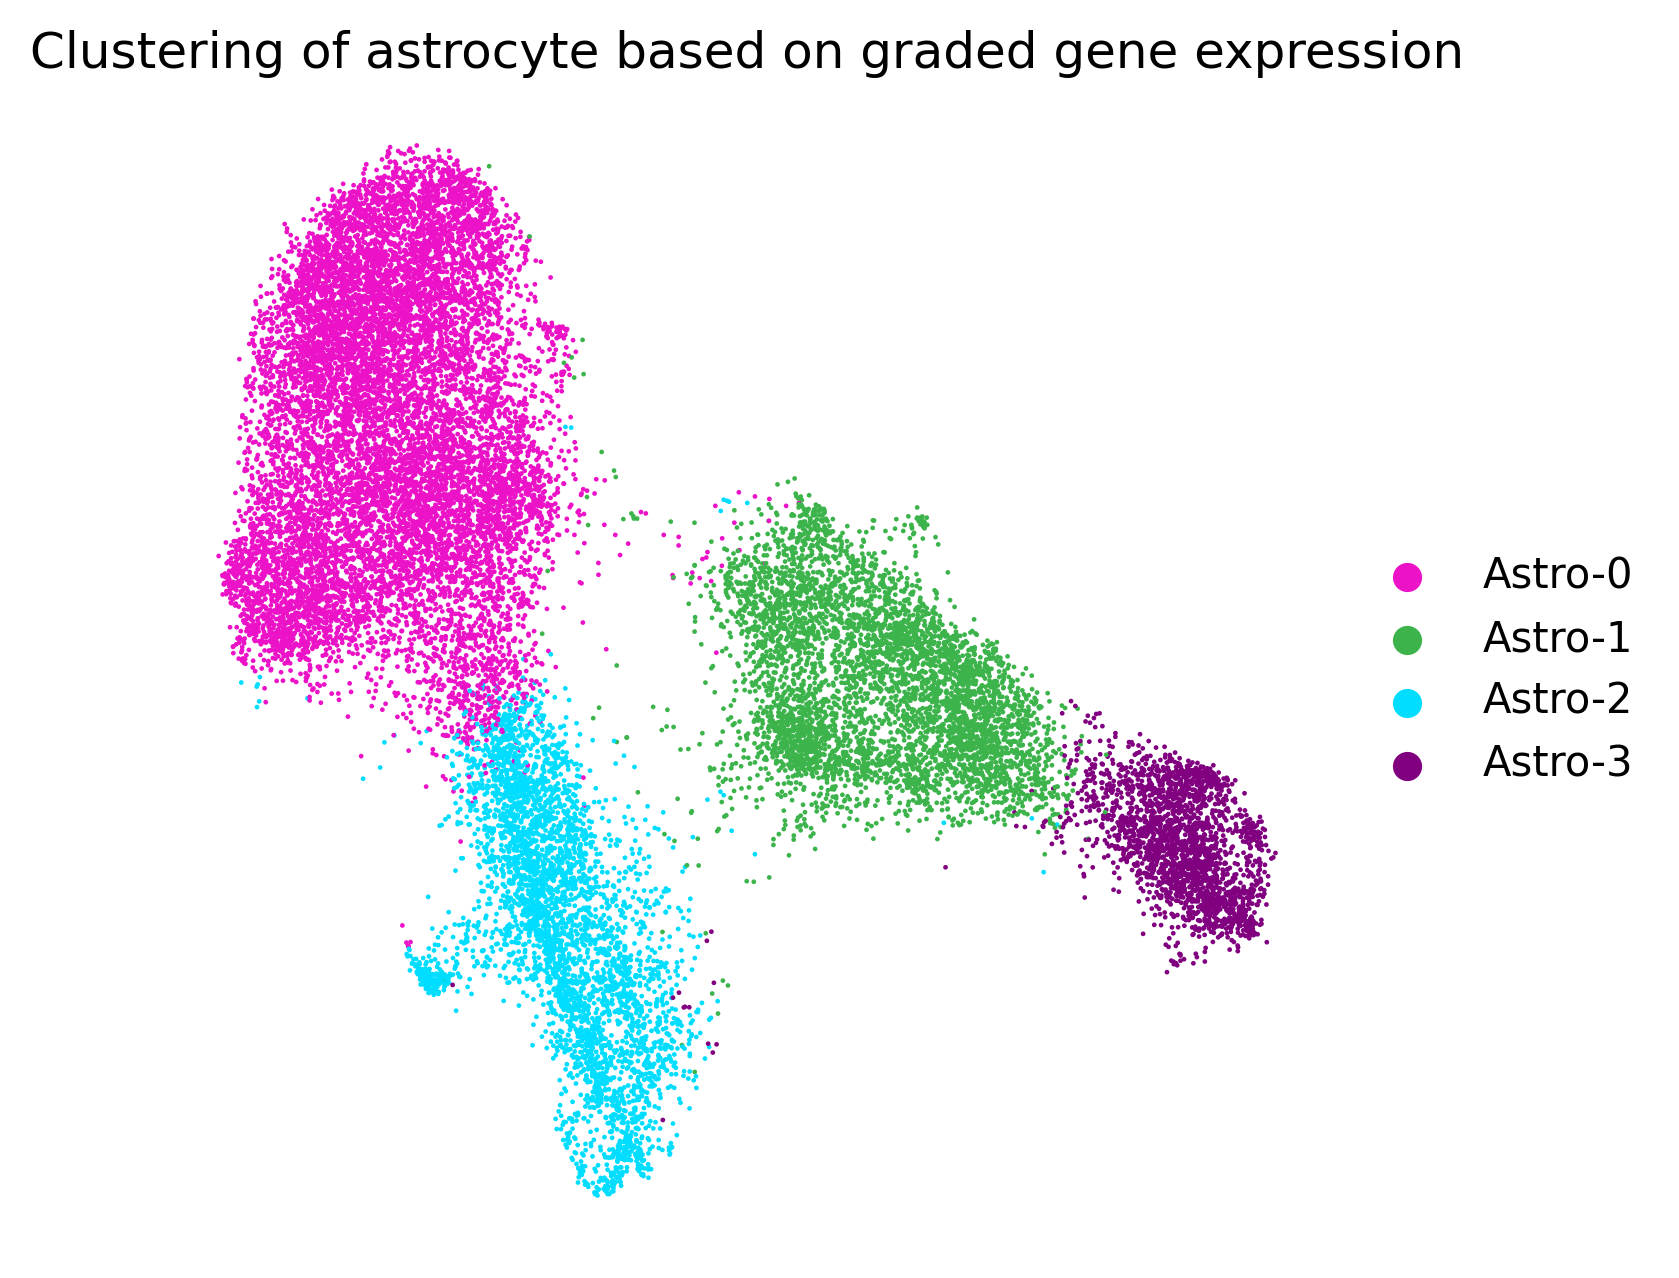

In [ ]:
import seaborn as sns
import os
import matplotlib.pyplot as plt 
fig,ax = plt.subplots(1,1, figsize = (5,5), dpi = 300)
cmap = ["#EB12C7","#3cb44b", "#00DDFF",'#800080']
# cmap = ["#EB12C7","#ee1109", "#00DDFF",'#800080']
sc.pl.umap(subadata,color = ['leiden_annotated'], palette = cmap, ax = ax, show = False,  frameon = False, title = 'Clustering of astrocyte based on graded gene expression' )
figure_title = 'geneGradient_based_astrocytesubtype_umap_1311p'
plt.savefig(r'./figures/StriosomeFocus_Figure' + os.sep + figure_title + '.png',bbox_inches = 'tight')
plt.savefig(r'./figures/StriosomeFocus_Figure' + os.sep + figure_title + '.tif',bbox_inches = 'tight')
plt.show()

In [ ]:
# save the clustered adata 
subadata.write_h5ad('./processed_data/AP34a_MERFISH/astrocyte_GradientGn_clustered.h5ad', compression='gzip')
subadata

AnnData object with n_obs × n_vars = 23320 × 74
    obs: 'volm', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'Neighborhood_label', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Class_label', 'Class_name', 'Class_bootstrapping_probability', 'Subclass_label', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Group_label', 'Group_name', 'Group_bootstrapping_probability', 'Cluster_label', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability', 'MatrixStriosome_label', 'striosome_distance', 'leiden_annotated'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'Ensemble_ID'
    uns: 'Class_name_colors', 'Group_name_colors', 'Subclass_name_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_gene

- Spatial plots of the clustsers 

In [ ]:
donor_1311_posterior_spatialModuleContours = np.load(r'./processed_data/AP34a_MERFISH/spatialModule_Contourcoord.npy',allow_pickle = True).item()
donor_1311_posterior_StriosomeContours = np.load(r'./processed_data/AP34a_MERFISH/Striosome_Contourcoord.npy',allow_pickle = True).item()


- Check the spatial map 

In [ ]:
# load in the metadata and striosome contours 
meta = pd.read_csv(r'./processed_data/AP34a_MERFISH/Striosome_analyzed_metadata.csv', index_col = 0)
strio_contour = np.load(r'./processed_data/AP34a_MERFISH/Striosome_contours.npy',allow_pickle = True).item()['contours']
subadata.obs['Striosome_label'] = meta.loc[subadata.obs_names,'Striosome_label']

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


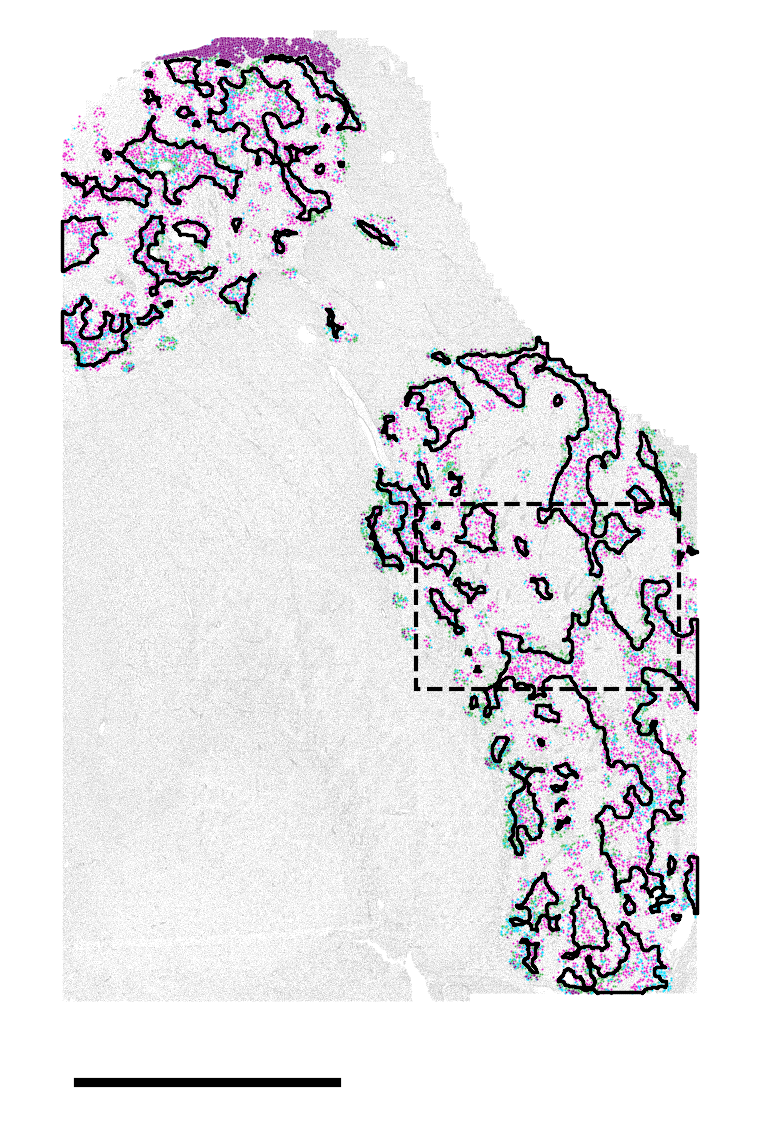

In [ ]:
import seaborn as sns
import os
import matplotlib.patches as patches
nobox = False
figure_title = 'Donor_1311p_striosome_astrocyte'
dx,dy = np.abs(np.ptp(MERFISH_adata.obsm['X_spatial_rotated'], axis = 0))
figsize_scale = 8e3
dx = dx/figsize_scale
dy = dy/figsize_scale
fig,ax = plt.subplots(1,1, dpi = 300, figsize = (dx,dy))
sns.scatterplot(x = MERFISH_adata.obsm['X_spatial_rotated'][:,0],y = MERFISH_adata.obsm['X_spatial_rotated'][:,1], s = 0.005, c = 'gray', ax = ax)



X = subadata.obsm['X_spatial_rotated'].copy()

for ld_clr,ld in zip(subadata.uns['leiden_colors'],subadata.obs['leiden'].cat.categories):
    keep = (subadata.obs['leiden'] == ld).values
    sns.scatterplot(x = X[keep,0],y = X[keep,1], s = 0.25, c = ld_clr, ax = ax)

# add the striosome contour outline
for cnt in donor_1311_posterior_StriosomeContours['Striosome']:
    sns.scatterplot(x = cnt[:,0],y = cnt[:,1], s = 0.5, facecolor = 'k',edgecolor = 'k', ax = ax)      


# add zoom-in box 
# bbox2 = patches.Rectangle((850,1000),10000,7000, fill = False, lw = 1, ls = '--')
bbox2 = patches.Rectangle((900,50),10000,7000, fill = False, lw = 1, ls = '--')
if not nobox:
    ax.add_patch(bbox2)

# add the outregion outlines 
# cnt = donor_1311_posterior_spatialModuleContours
# for label_ in ['Caudate','Putamen','NAC_shell','NAC_core','Gpi','Gpe',]:
#     if label_ in cnt:
#         if isinstance(cnt[label_],list):
#             for i in range(len(cnt[label_])):
#                 ax.plot(cnt[label_][i][:,0],cnt[label_][i][:,1], lw = 0.3, c = 'k')
#         else:
#             ax.plot(cnt[label_][:,0],cnt[label_][:,1], lw = 0.3, c = 'k')

xmax, ymax = MERFISH_adata.obsm['X_spatial_rotated'].max(axis=0)
xmin, ymin = MERFISH_adata.obsm['X_spatial_rotated'].min(axis=0)
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax + 3500])
# add scale bar
scalebar = patches.Rectangle([xmin + 500,1*ymax + 3000],10000,200,color = 'k')
ax.add_patch(scalebar)

ax.invert_yaxis()
ax.set_axis_off()
ax.set_aspect('equal',adjustable='datalim')
if not nobox:
    plt.savefig(r'./figures/StriosomeFocus_Figure' + os.sep + figure_title + '.png',bbox_inches = 'tight')
    plt.savefig(r'./figures/StriosomeFocus_Figure' + os.sep + figure_title + '.tif',bbox_inches = 'tight')
else:
    plt.savefig(r'./figures/StriosomeFocus_Figure' + os.sep + figure_title + '_nobox.png',bbox_inches = 'tight')
    plt.savefig(r'./figures/StriosomeFocus_Figure'+ os.sep + figure_title + '_nobox.tif',bbox_inches = 'tight')



plt.show()

    

- Plot the zoom-in box separately 

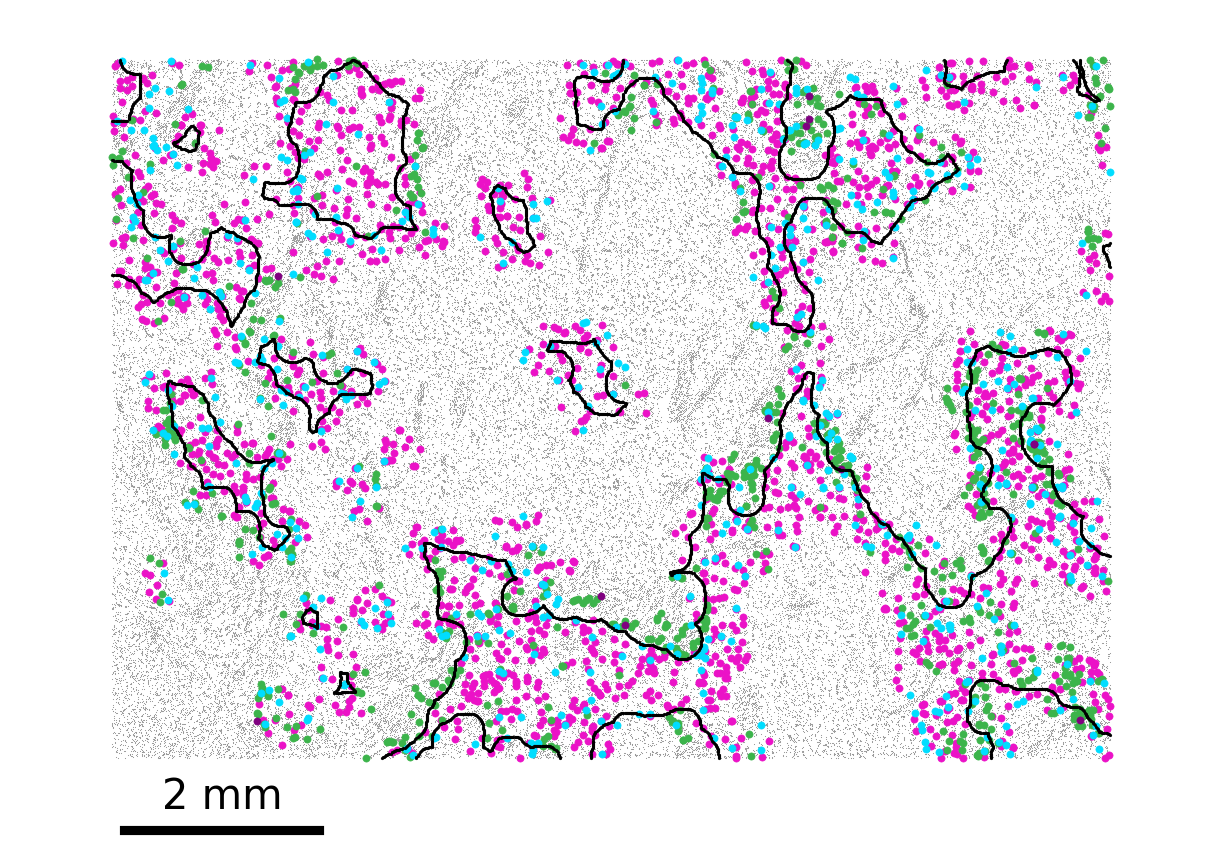

In [ ]:
figsize_scale = 2e3
xmin,ymin, xmax, ymax = np.array(bbox2.get_bbox()).ravel()
cond1 = (MERFISH_adata.obsm['X_spatial_rotated'][:,0] >= xmin) & (MERFISH_adata.obsm['X_spatial_rotated'][:,0] <= xmax)
cond2 = (MERFISH_adata.obsm['X_spatial_rotated'][:,1] >= ymin) & (MERFISH_adata.obsm['X_spatial_rotated'][:,1] <= ymax)

dx,dy = np.abs(np.ptp(MERFISH_adata.obsm['X_spatial_rotated'][cond1 & cond2], axis = 0))
dx = dx/figsize_scale
dy = dy/figsize_scale
nobox = False

fig,ax = plt.subplots(1,1,dpi = 300, figsize = (dx, dy))

sns.scatterplot(x = MERFISH_adata[cond1 & cond2].obsm['X_spatial_rotated'][:,0],y = MERFISH_adata[cond1 & cond2].obsm['X_spatial_rotated'][:,1], s = 0.07, c = 'gray', ax = ax)


ax.set_axis_off()
# # Plot the Striosome contours
# for i,cont in enumerate(strio_contour):
#     strio_cond1 = (cont[:,0] >= xmin) & (cont[:,0] <= xmax)
#     strio_cond2 = (cont[:,1] >= ymin) & (cont[:,1] <= ymax)
#     cnt_ = cont[strio_cond1 & strio_cond2,:]
#     if cnt_.size > 0:
#         cnt_ = np.vstack([cnt_,cnt_[0,:]])
#         ax.plot(cnt_[:,0],cnt_[:,1],'k',lw = 0.4)
#         # sns.scatterplot(x = cnt_[:,0],y = cnt_[:,1],c = 'k',ax = ax, s = 5)

X = subadata.obsm['X_spatial_rotated'].copy()

for ld_clr,ld in zip(subadata.uns['leiden_colors'],subadata.obs['leiden'].cat.categories):
    ld_keep = (subadata.obs['leiden'] == ld).values
    cond1 = (subadata.obsm['X_spatial_rotated'][:,0] >= xmin) & (subadata.obsm['X_spatial_rotated'][:,0] <= xmax)
    cond2 = (subadata.obsm['X_spatial_rotated'][:,1] >= ymin) & (subadata.obsm['X_spatial_rotated'][:,1] <= ymax)
    sns.scatterplot(x = X[ld_keep & cond1 & cond2,0],y = X[ld_keep & cond1 & cond2,1], s = 3, facecolor = ld_clr,edgecolor = ld_clr, ax = ax)


# add the striosome contour outline
for cnt in donor_1311_posterior_StriosomeContours['Striosome']:
    strio_cond1 = (cnt[:,0] >= xmin) & (cnt[:,0] <= xmax)
    strio_cond2 = (cnt[:,1] >= ymin) & (cnt[:,1] <= ymax)
    sns.scatterplot(x = cnt[strio_cond1 & strio_cond2,0],y = cnt[strio_cond1 & strio_cond2,1], s = 0.5, facecolor = 'k',edgecolor = 'k', ax = ax)      


# add scalebar 
xmin,ymin = np.min(X[cond1 & cond2],axis = 0)
xmax,ymax = np.max(X[cond1 & cond2],axis = 0)
import matplotlib.patches as patches
scalebar = patches.Rectangle([xmin + 100, ymax + 700],2000,50, color = 'k')
ax.add_patch(scalebar)
ax.text(xmin + 500, ymax + 500, '2 mm')

ax.set_ylim([ymin - 300,ymax + 800])
ax.invert_yaxis()
ax.set_aspect('equal',adjustable='datalim')
figure_title = '1311P_Striosome_astrocyte_zoominView'
plt.savefig(r'./figures/StriosomeFocus_Figure' + os.sep + figure_title + '.png',bbox_inches = 'tight')
plt.savefig(r'./figures/StriosomeFocus_Figure' + os.sep + figure_title + '.tif',bbox_inches = 'tight')





- Supplemental panel

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


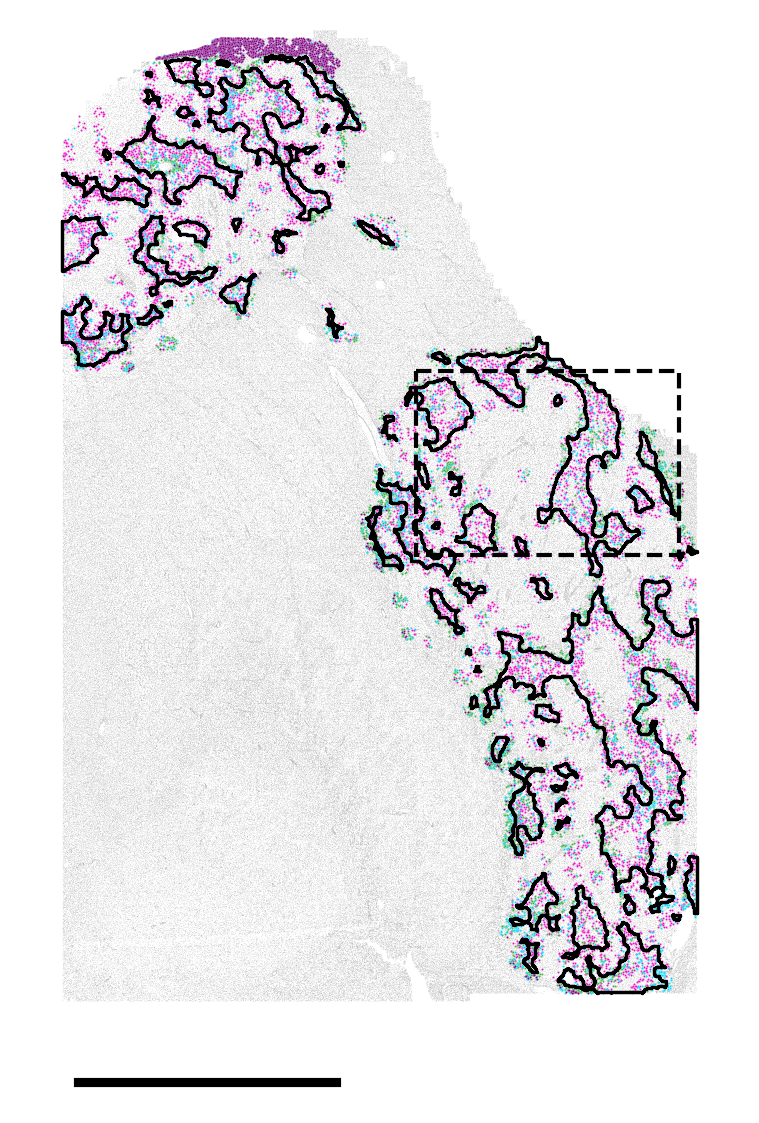

In [ ]:
import seaborn as sns
import os
import matplotlib.patches as patches
nobox = False
figure_title = 'Donor_1311p_striosome_astrocyte_supplemntal'
dx,dy = np.abs(np.ptp(MERFISH_adata.obsm['X_spatial_rotated'], axis = 0))
figsize_scale = 8e3
dx = dx/figsize_scale
dy = dy/figsize_scale
fig,ax = plt.subplots(1,1, dpi = 300, figsize = (dx,dy))
sns.scatterplot(x = MERFISH_adata.obsm['X_spatial_rotated'][:,0],y = MERFISH_adata.obsm['X_spatial_rotated'][:,1], s = 0.005, c = 'gray', ax = ax)



X = subadata.obsm['X_spatial_rotated'].copy()

for ld_clr,ld in zip(subadata.uns['leiden_colors'],subadata.obs['leiden'].cat.categories):
    keep = (subadata.obs['leiden'] == ld).values
    sns.scatterplot(x = X[keep,0],y = X[keep,1], s = 0.25, c = ld_clr, ax = ax)

# add the striosome contour outline
for cnt in donor_1311_posterior_StriosomeContours['Striosome']:
    sns.scatterplot(x = cnt[:,0],y = cnt[:,1], s = 0.5, facecolor = 'k',edgecolor = 'k', ax = ax)      


# add zoom-in box 
# bbox2 = patches.Rectangle((850,1000),10000,7000, fill = False, lw = 1, ls = '--')
bbox2 = patches.Rectangle((900,-5000),10000,7000, fill = False, lw = 1, ls = '--')
if not nobox:
    ax.add_patch(bbox2)

# add the outregion outlines 
# cnt = donor_1311_posterior_spatialModuleContours
# for label_ in ['Caudate','Putamen','NAC_shell','NAC_core','Gpi','Gpe',]:
#     if label_ in cnt:
#         if isinstance(cnt[label_],list):
#             for i in range(len(cnt[label_])):
#                 ax.plot(cnt[label_][i][:,0],cnt[label_][i][:,1], lw = 0.3, c = 'k')
#         else:
#             ax.plot(cnt[label_][:,0],cnt[label_][:,1], lw = 0.3, c = 'k')

xmax, ymax = MERFISH_adata.obsm['X_spatial_rotated'].max(axis=0)
xmin, ymin = MERFISH_adata.obsm['X_spatial_rotated'].min(axis=0)
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax + 3500])
# add scale bar
scalebar = patches.Rectangle([xmin + 500,1*ymax + 3000],10000,200,color = 'k')
ax.add_patch(scalebar)

ax.invert_yaxis()
ax.set_axis_off()
ax.set_aspect('equal',adjustable='datalim')
if not nobox:
    plt.savefig(r'./figures/StriosomeFocus_Figure' + os.sep + figure_title + '.png',bbox_inches = 'tight')
    plt.savefig(r'./figures/StriosomeFocus_Figure' + os.sep + figure_title + '.tif',bbox_inches = 'tight')
else:
    plt.savefig(r'./figures/StriosomeFocus_Figure' + os.sep + figure_title + '_nobox.png',bbox_inches = 'tight')
    plt.savefig(r'./figures/StriosomeFocus_Figure'+ os.sep + figure_title + '_nobox.tif',bbox_inches = 'tight')



plt.show()

    

- Supplemental zoom-in

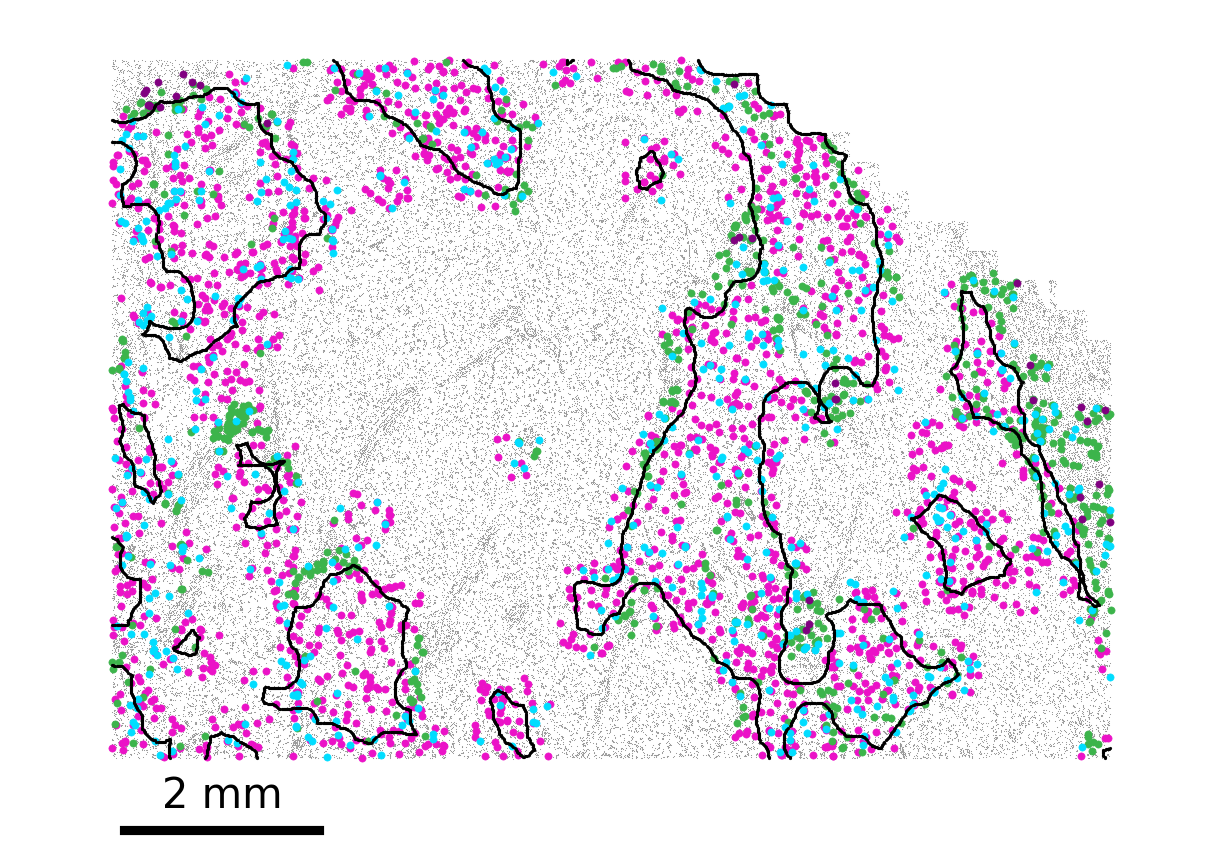

In [ ]:
figsize_scale = 2e3
xmin,ymin, xmax, ymax = np.array(bbox2.get_bbox()).ravel()
cond1 = (MERFISH_adata.obsm['X_spatial_rotated'][:,0] >= xmin) & (MERFISH_adata.obsm['X_spatial_rotated'][:,0] <= xmax)
cond2 = (MERFISH_adata.obsm['X_spatial_rotated'][:,1] >= ymin) & (MERFISH_adata.obsm['X_spatial_rotated'][:,1] <= ymax)

dx,dy = np.abs(np.ptp(MERFISH_adata.obsm['X_spatial_rotated'][cond1 & cond2], axis = 0))
dx = dx/figsize_scale
dy = dy/figsize_scale
nobox = False

fig,ax = plt.subplots(1,1,dpi = 300, figsize = (dx, dy))

sns.scatterplot(x = MERFISH_adata[cond1 & cond2].obsm['X_spatial_rotated'][:,0],y = MERFISH_adata[cond1 & cond2].obsm['X_spatial_rotated'][:,1], s = 0.07, c = 'gray', ax = ax)


ax.set_axis_off()
# # Plot the Striosome contours
# for i,cont in enumerate(strio_contour):
#     strio_cond1 = (cont[:,0] >= xmin) & (cont[:,0] <= xmax)
#     strio_cond2 = (cont[:,1] >= ymin) & (cont[:,1] <= ymax)
#     cnt_ = cont[strio_cond1 & strio_cond2,:]
#     if cnt_.size > 0:
#         cnt_ = np.vstack([cnt_,cnt_[0,:]])
#         ax.plot(cnt_[:,0],cnt_[:,1],'k',lw = 0.4)
#         # sns.scatterplot(x = cnt_[:,0],y = cnt_[:,1],c = 'k',ax = ax, s = 5)

X = subadata.obsm['X_spatial_rotated'].copy()

for ld_clr,ld in zip(subadata.uns['leiden_colors'],subadata.obs['leiden'].cat.categories):
    ld_keep = (subadata.obs['leiden'] == ld).values
    cond1 = (subadata.obsm['X_spatial_rotated'][:,0] >= xmin) & (subadata.obsm['X_spatial_rotated'][:,0] <= xmax)
    cond2 = (subadata.obsm['X_spatial_rotated'][:,1] >= ymin) & (subadata.obsm['X_spatial_rotated'][:,1] <= ymax)
    sns.scatterplot(x = X[ld_keep & cond1 & cond2,0],y = X[ld_keep & cond1 & cond2,1], s = 3, facecolor = ld_clr,edgecolor = ld_clr, ax = ax)


# add the striosome contour outline
for cnt in donor_1311_posterior_StriosomeContours['Striosome']:
    strio_cond1 = (cnt[:,0] >= xmin) & (cnt[:,0] <= xmax)
    strio_cond2 = (cnt[:,1] >= ymin) & (cnt[:,1] <= ymax)
    sns.scatterplot(x = cnt[strio_cond1 & strio_cond2,0],y = cnt[strio_cond1 & strio_cond2,1], s = 0.5, facecolor = 'k',edgecolor = 'k', ax = ax)      


# add scalebar 
xmin,ymin = np.min(X[cond1 & cond2],axis = 0)
xmax,ymax = np.max(X[cond1 & cond2],axis = 0)
import matplotlib.patches as patches
scalebar = patches.Rectangle([xmin + 100, ymax + 700],2000,50, color = 'k')
ax.add_patch(scalebar)
ax.text(xmin + 500, ymax + 500, '2 mm')

ax.set_ylim([ymin - 300,ymax + 800])
ax.invert_yaxis()
ax.set_aspect('equal',adjustable='datalim')
figure_title = '1311P_Striosome_astrocyte_zoominView_supplemental'
plt.savefig(r'./figures/StriosomeFocus_Figure' + os.sep + figure_title + '.png',bbox_inches = 'tight')
plt.savefig(r'./figures/StriosomeFocus_Figure' + os.sep + figure_title + '.tif',bbox_inches = 'tight')



